# Butterfly Classification

Выполним классификацию [бабочек](https://www.kaggle.com/datasets/phucthaiv02/butterfly-image-classification) с использованием модели [Google's EfficientNet V2](https://www.kaggle.com/models/google/efficientnet-v2).

# Import Libraries

In [1]:
%%capture

import numpy as np
import pandas as pd
import os
import random

import matplotlib.pyplot as plt

from PIL import Image

import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
from keras.layers import Dense, Dropout, Conv2D

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from tqdm import tqdm

# Disable error output
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# Detect Current Accelerator

Для быстрого обучения будем использовать Tensor Processing Units (TPU).

In [2]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection.
    print('Running on TPU ', tpu.master())
except ValueError:
    print("No TPUs detected")
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  


2023-11-17 15:13:55.956116: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-17 15:13:55.956231: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-17 15:13:55.956305: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-17 15:13:55.956389: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-17 15:13:55.956517: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-17 15:13:55.956727: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-17 15:13:55.956810: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

REPLICAS:  8


# Load Data

In [3]:
INPUT_DIR = "../input/butterfly-image-classification"
TRAIN_DIR = f"{INPUT_DIR}/train"
TEST_DIR = f"{INPUT_DIR}/test"

meta_df = pd.read_csv(os.path.join(INPUT_DIR, "Training_set.csv"))
meta_df.head()

filename                     label
0  Image_1.jpg          SOUTHERN DOGFACE
1  Image_2.jpg                    ADONIS
2  Image_3.jpg            BROWN SIPROETA
3  Image_4.jpg                   MONARCH
4  Image_5.jpg  GREEN CELLED CATTLEHEART

In [4]:
meta_df.shape

(6499, 2)

## Data Pre-Processing

Сформируем датасет с картинками и классами (label).

К классам применим LabelEncoder, чтобы от категориальных признаков перейти к численным

In [5]:
%%capture

images = []
labels = []
label_encodings = []

label_encoder = LabelEncoder()
meta_df["label_encoding"] = label_encoder.fit_transform(meta_df["label"])
pbar = tqdm(list(meta_df.iterrows()))

for index, entry in pbar:
    image = np.asarray(Image.open(os.path.join(TRAIN_DIR, entry["filename"])))
    label = entry["label"]
    label_encoding = entry["label_encoding"]
    
    images.append(image)
    labels.append(label)
    label_encodings.append(label_encoding)

Посмотрим на размеры первого изображения:

In [6]:
images[0].shape

(224, 224, 3)

Классы имеют следующий вид:

In [7]:
labels[0:10]

['SOUTHERN DOGFACE',
 'ADONIS',
 'BROWN SIPROETA',
 'MONARCH',
 'GREEN CELLED CATTLEHEART',
 'CAIRNS BIRDWING',
 'GREEN CELLED CATTLEHEART',
 'EASTERN DAPPLE WHITE',
 'BROWN SIPROETA',
 'RED POSTMAN']

Те же классы в численном выражении:

In [8]:
label_encodings[0:10]

[66, 0, 12, 44, 33, 14, 33, 27, 12, 60]

## Visualizing Data

Рассмотрим несколько картинок из датасета.

<Figure size 640x480 with 0 Axes>

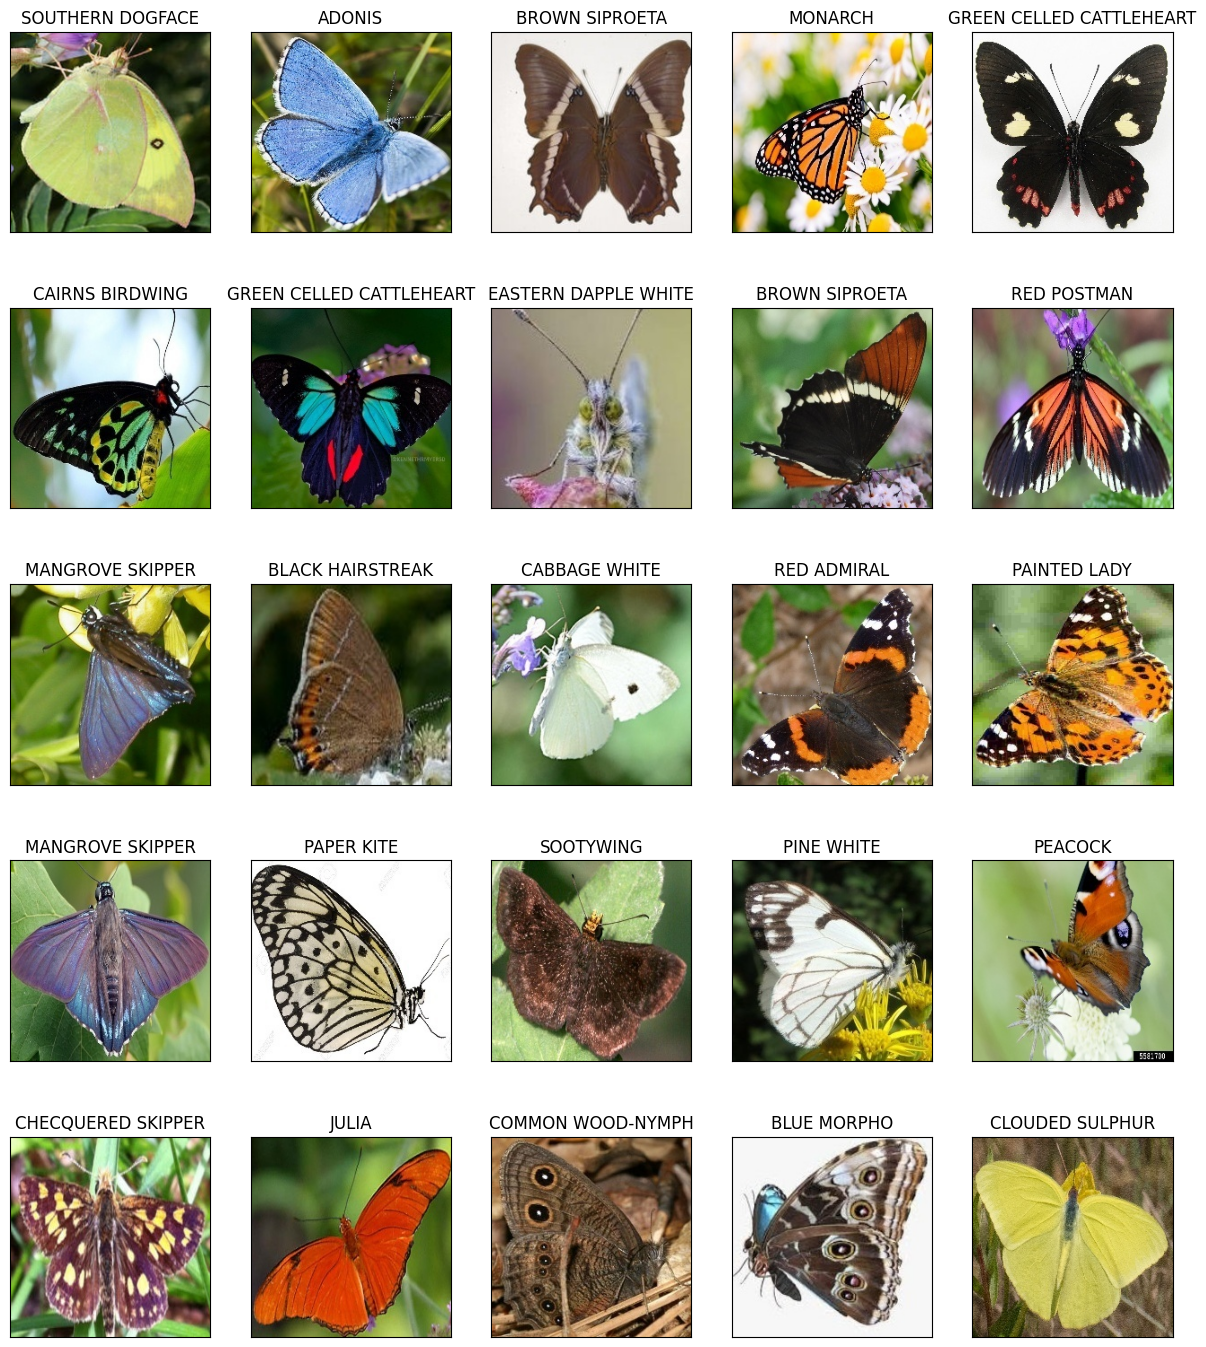

In [9]:
plt.tight_layout()
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(15,15))
plt.subplots_adjust(top=1.0)

for idx, ax in enumerate(axes.flat):
    image = images[idx]
    label_name = labels[idx]
    
    ax.imshow(image)
    ax.set(title=label_name)
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

## Distribution of Labels

Посмотрим на распределение целевой переменной.

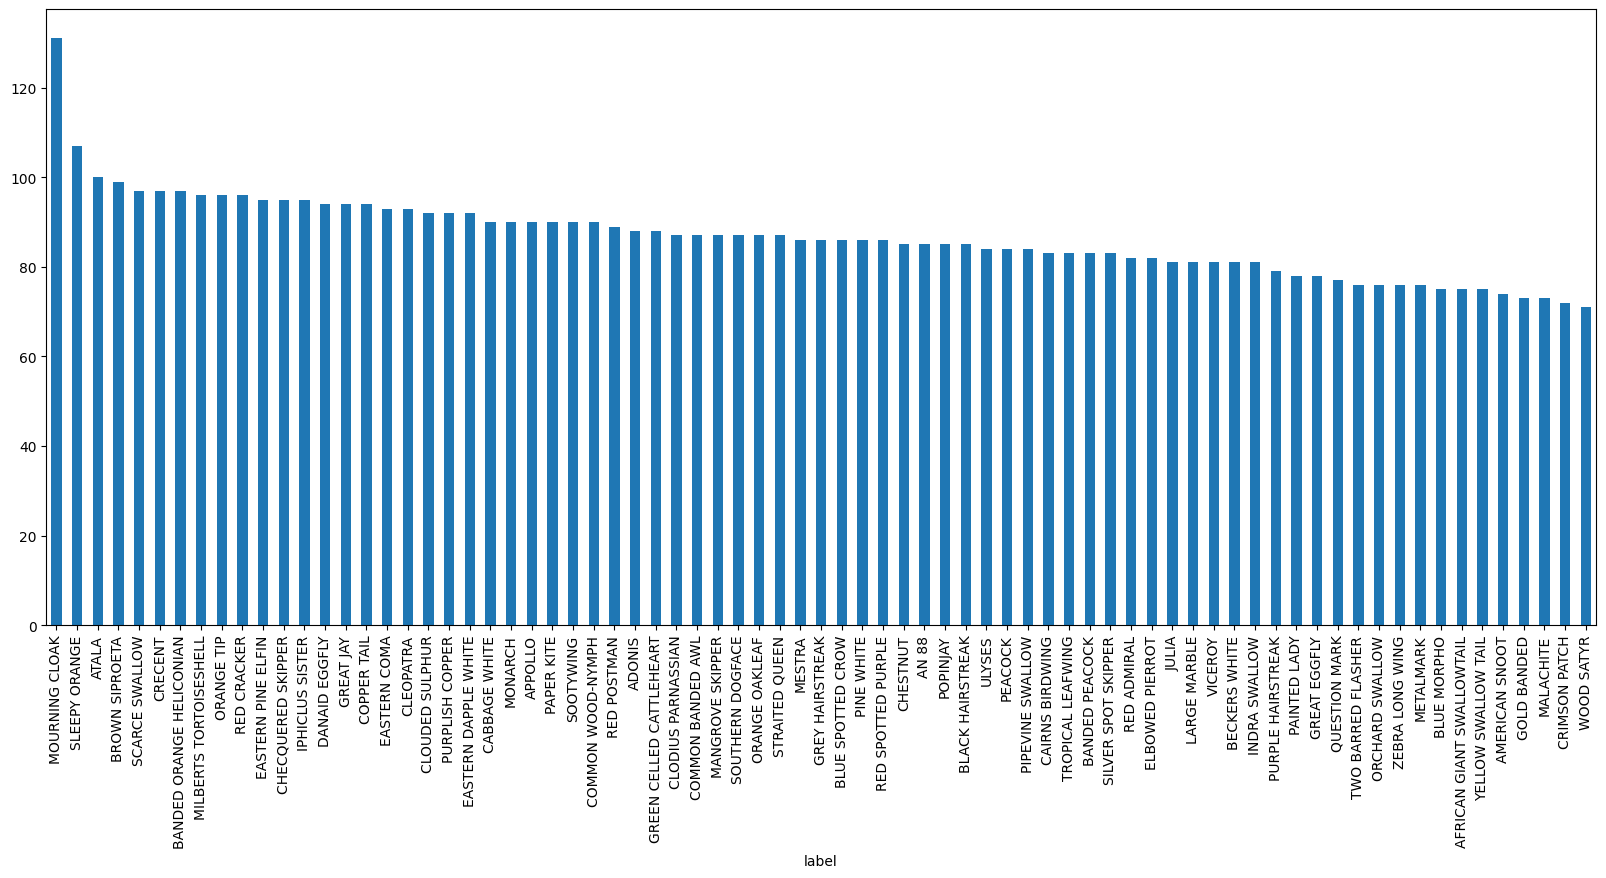

In [10]:
plt.figure(figsize=(20, 8))
meta_df["label"].value_counts().plot(kind="bar")
plt.show()

# Modelling

Мы будем использовать нейронную сеть с Efficient Net V2 для классификации различных категорий бабочек.

In [11]:
with strategy.scope():
    efficient_net = hub.KerasLayer("https://www.kaggle.com/models/google/efficientnet-v2/frameworks/TensorFlow2/variations/imagenet21k-b3-feature-vector/versions/1",
                   trainable=False)
    
    model = keras.Sequential([
        efficient_net,
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(75, activation='softmax'),
    ])
    
    model.build([None, 224, 224, 3])
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=5e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

2023-11-17 15:14:58.791528: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-17 15:14:58.791659: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


Наша модель имеет следующий вид:

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1536)              12930622  
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 75)                9675      
                                                                 
Total params: 13366665 (50.99 MB)
Trainable params: 436043 (1.66 MB)
Non-trainable params: 12930622 (49.33 MB)
_________________________________________________________________


## Training the Model


Теперь мы скомпилируем и обучим модель. Сначала нам нужно преобразовать наши изображения и метки в массивы Numpy, а затем разделить наши изображения и метки на обучающий и тестовый наборы:

In [13]:
np_images = np.asarray(images).astype('float64') / 255
np_label_encodings = np.asarray(label_encodings).astype('float64')
print(f"Shape of images: {np_images.shape}")
print(f"Shape of label encodings: {np_label_encodings.shape}")

Shape of images: (6499, 224, 224, 3)
Shape of label encodings: (6499,)


In [14]:
images_train, images_test, label_encodings_train, label_encodings_test = train_test_split(np_images, np_label_encodings, train_size=0.7)
print(f"Shape of training images: {images_train.shape}")
print(f"Shape of training label encodings: {label_encodings_train.shape}")
print(f"Shape of validation images: {images_test.shape}")
print(f"Shape of validation label encodings: {label_encodings_test.shape}")

Shape of training images: (4549, 224, 224, 3)
Shape of training label encodings: (4549,)
Shape of validation images: (1950, 224, 224, 3)
Shape of validation label encodings: (1950,)


In [15]:
train_dataset = tf.data.Dataset.from_tensor_slices((images_train, label_encodings_train)).repeat().shuffle(10000).batch(64)
test_dataset = tf.data.Dataset.from_tensor_slices((images_test, label_encodings_test)).batch(1)

In [16]:
EPOCHS = 5
STEPS_PER_EPOCH = 2000
VALIDATION_STEPS = 1000

history = model.fit(train_dataset, epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=test_dataset)

Epoch 1/5


2023-11-17 15:15:25.658813: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-17 15:15:25.677879: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-17 15:15:25.695814: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-17 15:15:25.713186: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-17 15:15:25.730966: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-17 15:15:25.749517: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-17 15:15:25.766927: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

   2/2000 [..............................] - ETA: 4:17 - loss: 5.0483 - sparse_categorical_accuracy: 0.0312    

2023-11-17 15:15:46.484729: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-17 15:15:46.485077: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-17 15:15:46.485139: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-17 15:15:46.485224: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-17 15:15:46.485313: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-17 15:15:46.485392: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-17 15:15:46.485498: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

2000/2000 [==============================] - ETA: 0s - loss: 0.1286 - sparse_categorical_accuracy: 0.9705

2023-11-17 15:19:49.100474: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


2000/2000 [==============================] - 330s 155ms/step - loss: 0.1286 - sparse_categorical_accuracy: 0.9705 - val_loss: 0.5107 - val_sparse_categorical_accuracy: 0.8836
Epoch 2/5
2000/2000 [==============================] - 279s 139ms/step - loss: 0.0169 - sparse_categorical_accuracy: 0.9953 - val_loss: 0.5957 - val_sparse_categorical_accuracy: 0.8964
Epoch 3/5
2000/2000 [==============================] - 279s 140ms/step - loss: 0.0085 - sparse_categorical_accuracy: 0.9975 - val_loss: 0.6556 - val_sparse_categorical_accuracy: 0.8949
Epoch 4/5
2000/2000 [==============================] - 278s 139ms/step - loss: 0.0057 - sparse_categorical_accuracy: 0.9985 - val_loss: 0.6807 - val_sparse_categorical_accuracy: 0.9026
Epoch 5/5
2000/2000 [==============================] - 278s 139ms/step - loss: 0.0106 - sparse_categorical_accuracy: 0.9970 - val_loss: 0.7229 - val_sparse_categorical_accuracy: 0.9010


# Visualizing Model Accuracy

Мы можем визуализировать, насколько хорошо наша модель справляется с набором проверок, сопоставляя предсказания с изображениями в наборе проверок и проверяя, соответствуют ли они фактическим меткам.

2023-11-17 15:39:42.011548: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


25/25 [==============================] - 14s 31ms/step


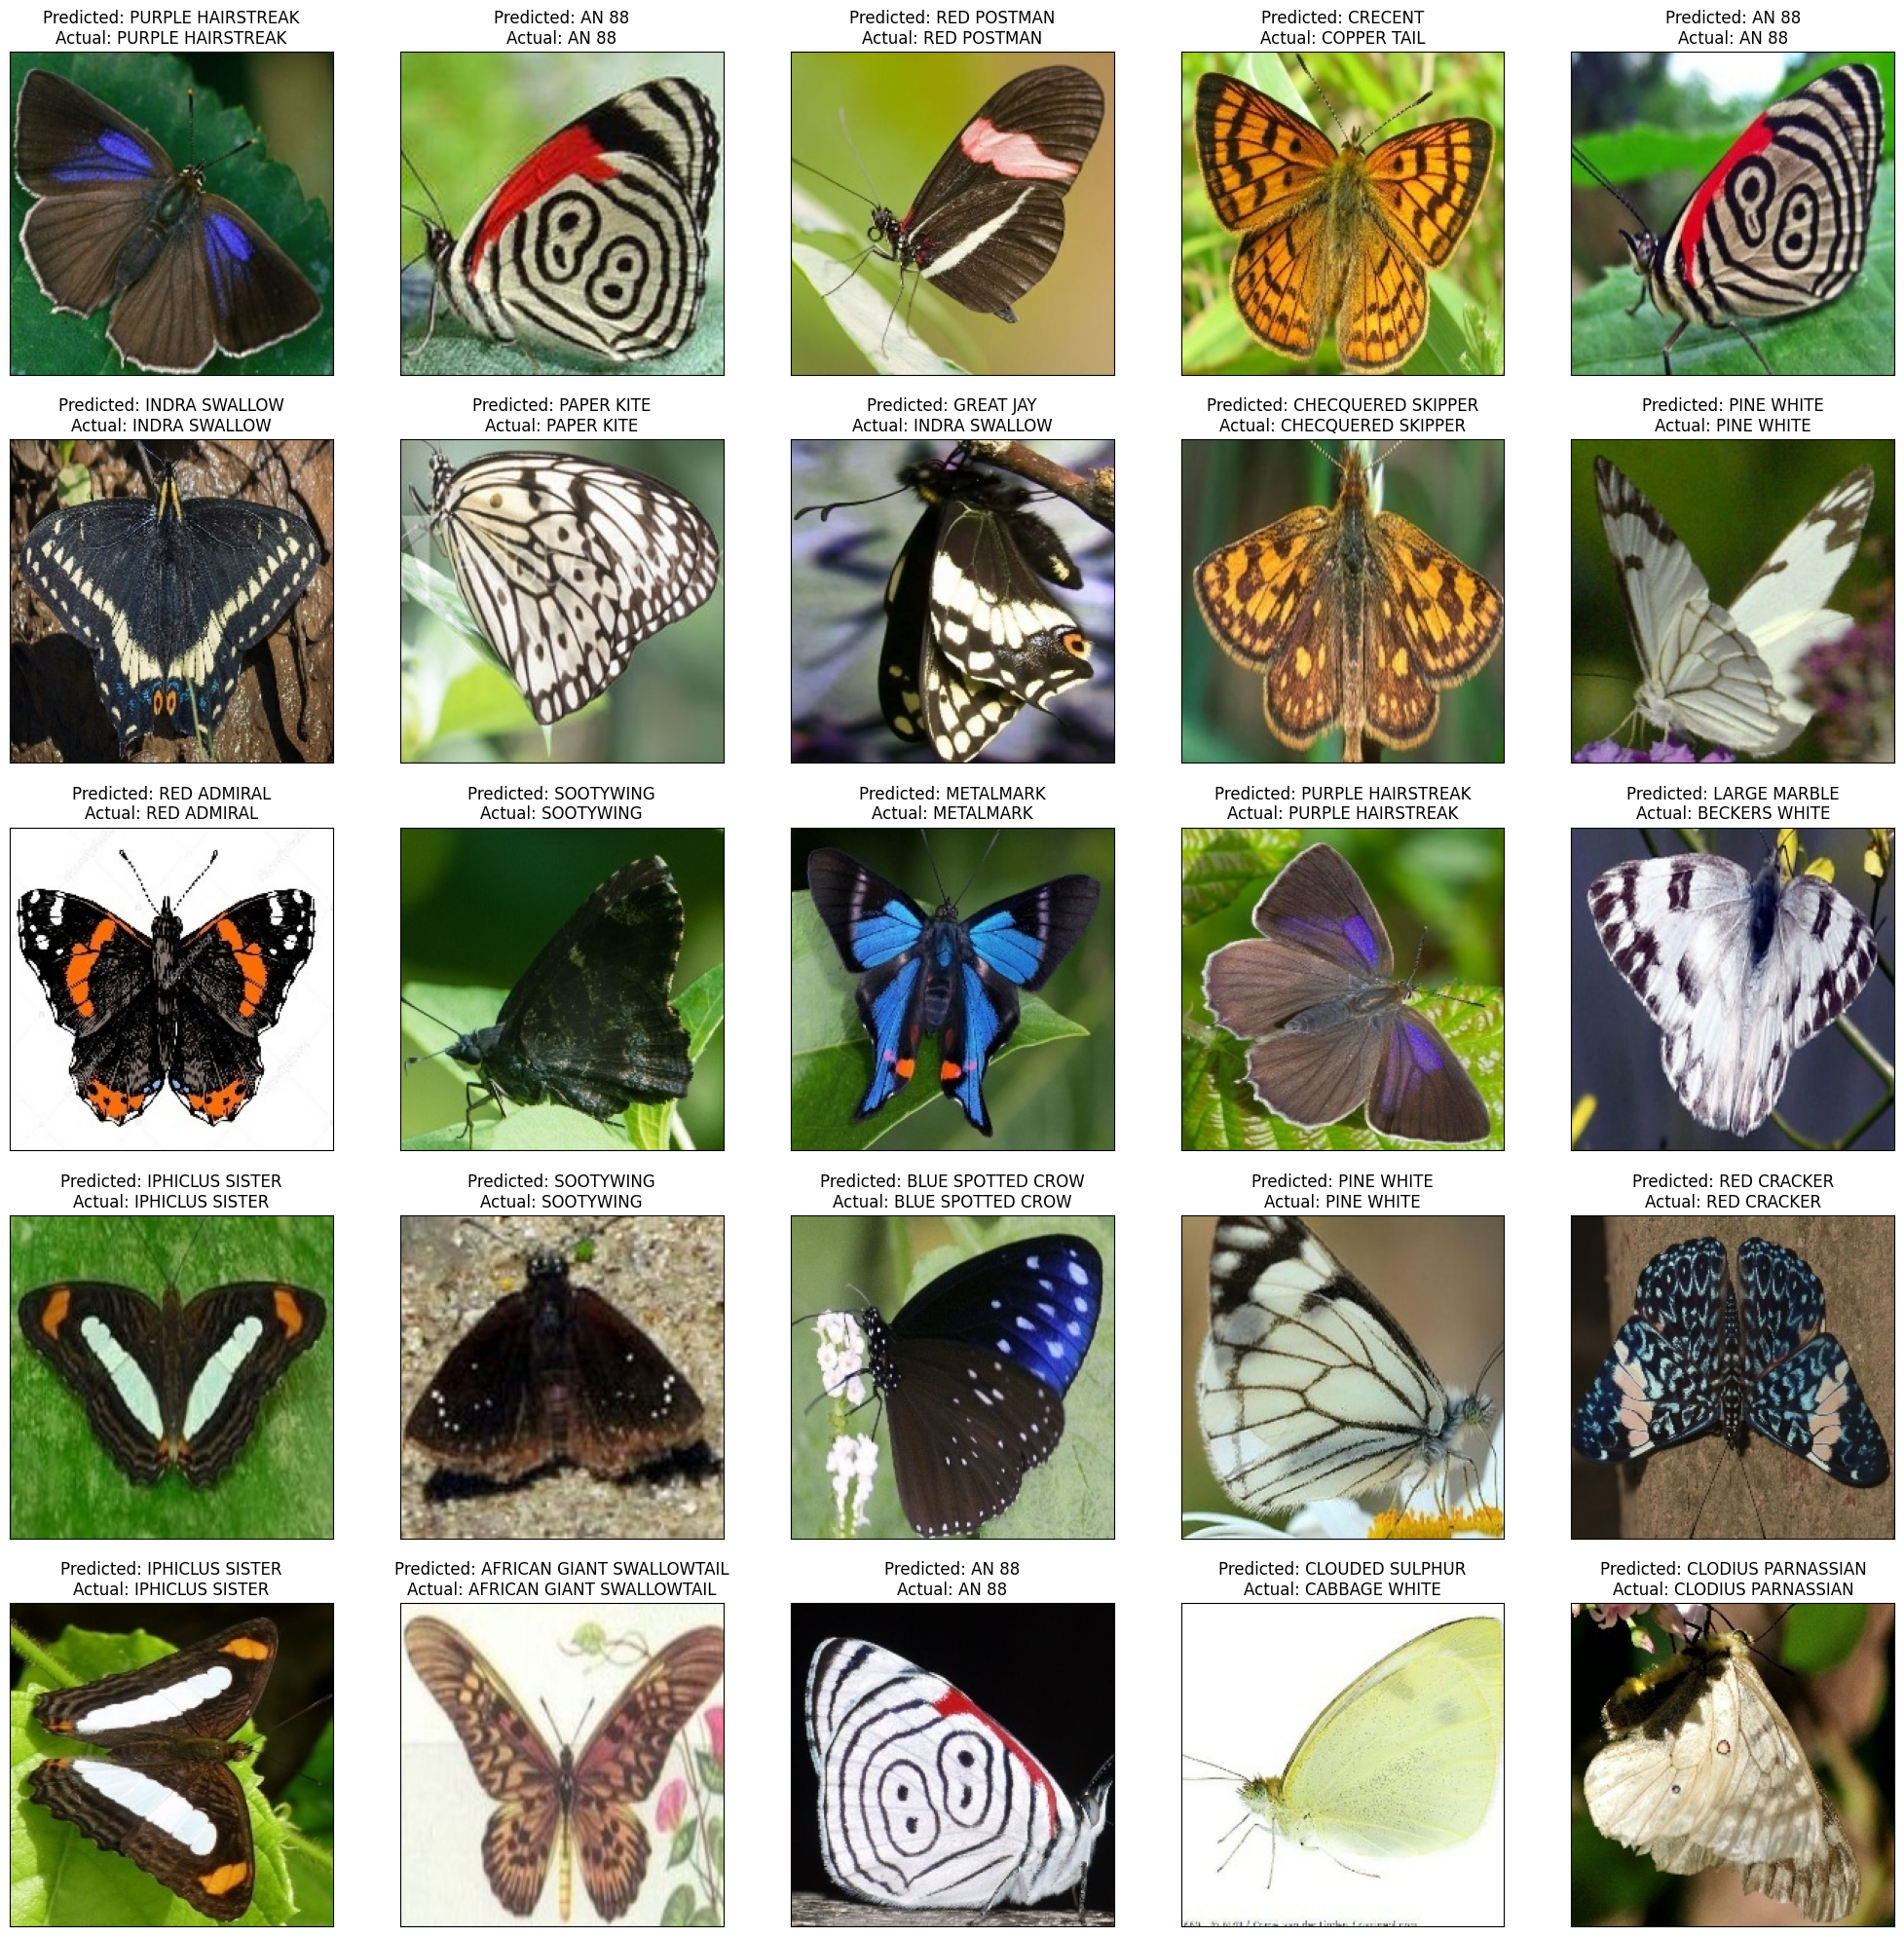

In [17]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(25,25))

sample_test_dataset = test_dataset.take(25)
sample_test_dataset_np = [(image, label_encoding) for (image, label_encoding) in sample_test_dataset]
predictions = model.predict(sample_test_dataset).argmax(axis=1)

for ax, (image, act_label_encoding), pred_label_encoding in zip(axes.flat, sample_test_dataset, predictions):
    actual_label_encoding_np = act_label_encoding.numpy().astype(int)
    actual_label_name = label_encoder.inverse_transform(actual_label_encoding_np)[0]
    
    pred_label_encoding_np = pred_label_encoding.astype(int)
    pred_label_name = label_encoder.inverse_transform([pred_label_encoding_np])[0]
    
    ax.imshow(image.numpy().reshape(224, 224, 3))
    ax.set(title=f"Predicted: {pred_label_name}\nActual: {actual_label_name}")
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.show()

# Evaluating Model

## Precision, Accuracy, Recall, F1

Оценим нашу модель:

In [18]:
test_predictions = model.predict(test_dataset).argmax(axis=1).astype(int)
test_actual = [label_encoding.numpy()[0].astype(int) for (image, label_encoding) in test_dataset]

1950/1950 [==============================] - 65s 31ms/step


In [19]:
print(f"Accuracy: {accuracy_score(test_predictions, test_actual)}")
print(f"Precision: {precision_score(test_predictions, test_actual, average='macro')}")
print(f"Recall: {recall_score(test_predictions, test_actual, average='macro')}")
print(f"F1 score: {f1_score(test_predictions, test_actual, average='macro')}")

Accuracy: 0.901025641025641
Precision: 0.9040105572528542
Recall: 0.9033526387794819
F1 score: 0.9012128220951928


## Confusion Matrix

Составим матрицу ошибок ("путаницы").

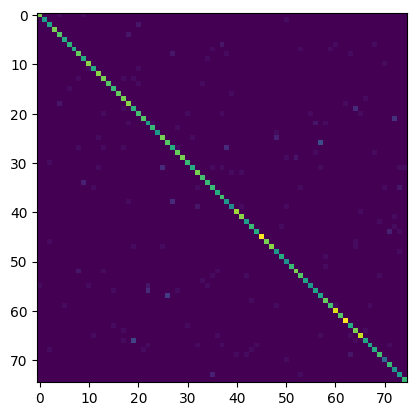

In [20]:
confusion_matrix = tf.math.confusion_matrix(test_actual, test_predictions)
plt.imshow(confusion_matrix)
plt.show()

## Save model

In [21]:
model.save('model.h5')
tf.saved_model.save(model, '/model')

INFO:tensorflow:Assets written to: model/assets


## Summary

Для повышения точности модели можно воспользоваться преобразованием изображений ImageDataGenerator. Что позволит увеличить выборку, но также значительно увеличит и время обучения модели

## 